За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Збір даних

Парсинг даних з утворенням нових ознак

In [2]:
main_directory = "./data"

subdirectories = [f.path for f in os.scandir(main_directory) if f.is_dir()]
dfs = []

for directory in subdirectories:
    files = [f for f in os.scandir(directory) if f.name.endswith('.csv')]
    
    for file in files:
        file_path = file.path
        df_temp = pd.read_csv(file_path)
        x = df_temp['accelerometer_X']
        y = df_temp['accelerometer_Y']
        z = df_temp['accelerometer_Z']
        df_temp['var_x'] = x.var()
        df_temp['std_y'] = y.std(ddof=0)
        df_temp['median_y'] = y.median()
        df_temp['max_x'] = x.max()
        df_temp['min_x'] = x.min()
        df_temp['rms_y'] = np.sqrt((y ** 2).mean())
        df_temp['skewness_y'] = y.skew()
        df_temp['skewness_z'] = z.skew()
        df_temp['kurtosis_z'] = z.kurtosis()
        df_temp['iqr_x'] = x.quantile(0.75) - x.quantile(0.25)
        df_temp['iqr_z'] = z.quantile(0.75) - z.quantile(0.25)
        df_temp['mad_x'] = np.mean(np.abs(x - np.mean(x)))
        df_temp['mad_y'] = np.mean(np.abs(y - np.mean(y)))
        df_temp['mad_z'] = np.mean(np.abs(z - np.mean(z)))
        df_temp['min_index_y'] = y.idxmin()
        
        df_temp['folder'] = os.path.basename(directory)
        df_temp['file'] = os.path.splitext(file.name)[0]
        
        dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,var_x,std_y,median_y,max_x,min_x,rms_y,skewness_y,skewness_z,kurtosis_z,iqr_x,iqr_z,mad_x,mad_y,mad_z,min_index_y,folder,file
0,1.000776,4.616021,8.576031,1.074044,1.138147,-0.131681,5.09965,-0.909797,1.150396,3.64747,-2.365312,4.369874,0.06584,0.034716,0.539706,0.566011,0.275546,2,idle,idle-1
1,0.718261,4.209007,8.446744,1.074044,1.138147,-0.131681,5.09965,-0.909797,1.150396,3.64747,-2.365312,4.369874,0.06584,0.034716,0.539706,0.566011,0.275546,2,idle,idle-1
2,-0.909797,-0.282516,9.203311,1.074044,1.138147,-0.131681,5.09965,-0.909797,1.150396,3.64747,-2.365312,4.369874,0.06584,0.034716,0.539706,0.566011,0.275546,2,idle,idle-1
3,5.099650,0.148441,8.418014,1.074044,1.138147,-0.131681,5.09965,-0.909797,1.150396,3.64747,-2.365312,4.369874,0.06584,0.034716,0.539706,0.566011,0.275546,2,idle,idle-1
4,1.762132,-0.162806,9.251195,1.074044,1.138147,-0.131681,5.09965,-0.909797,1.150396,3.64747,-2.365312,4.369874,0.06584,0.034716,0.539706,0.566011,0.275546,2,idle,idle-1


# Розділення даних

Розділення даних за файлом.30% для тренування

In [3]:
files = df.file.unique()
sample = np.random.choice(files, size=int(len(files)*0.3), replace=False)
train = df[df['file'].isin(sample)].reset_index(drop=True)

Решта файлів для тестів передбачення

In [4]:
test_files = np.setdiff1d(files, sample)
test = df[df['file'].isin(test_files)].reset_index(drop=True)

Розділення на ознаки для навчання та діяльність

In [5]:
x_train = train.drop(columns=['file', 'folder'])
y_train = train['folder']
x_test = test.drop(columns=['file', 'folder'])
y_test = test['folder']

# Нормалізація

Нормалізація даних для тренування

In [6]:
scaler = StandardScaler()
data_to_normalize = x_train[x_train.columns]

normalized_data = scaler.fit_transform(data_to_normalize)

x_n_train = x_train.copy()
x_n_train[x_train.columns] = normalized_data

Нормалізація даних для тестів

In [7]:
data_to_normalize = x_test[x_test.columns]

normalized_data = scaler.fit_transform(data_to_normalize)

x_n_test = x_test.copy()
x_n_test[x_test.columns] = normalized_data

# Навчання моделей

Навчання моделі Support vector machines на нормалізованих даних

In [8]:
model_svm = SVC()
model_svm.fit(x_n_train, y_train)

SVC()

Навчання моделі Random Forest на оригінальних даних

In [9]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

RandomForestClassifier()

# Передбачення

Передбачення на нормалізованих даних для SVM, та оригінальних даних для Random Forest відповідно. Підрахунок точності передбачення

In [10]:
y_pred_svm = model_svm.predict(x_n_test)
y_pred_rf = model_rf.predict(x_test)

svm_score = accuracy_score(y_test, y_pred_svm)
rf_score = accuracy_score(y_test, y_pred_rf)

# Візуалізація

Візуалізація обох моделей

Точність моделі SVM:0.9929634541703507
Точність моделі випадкового лісу:0.9951444149720011


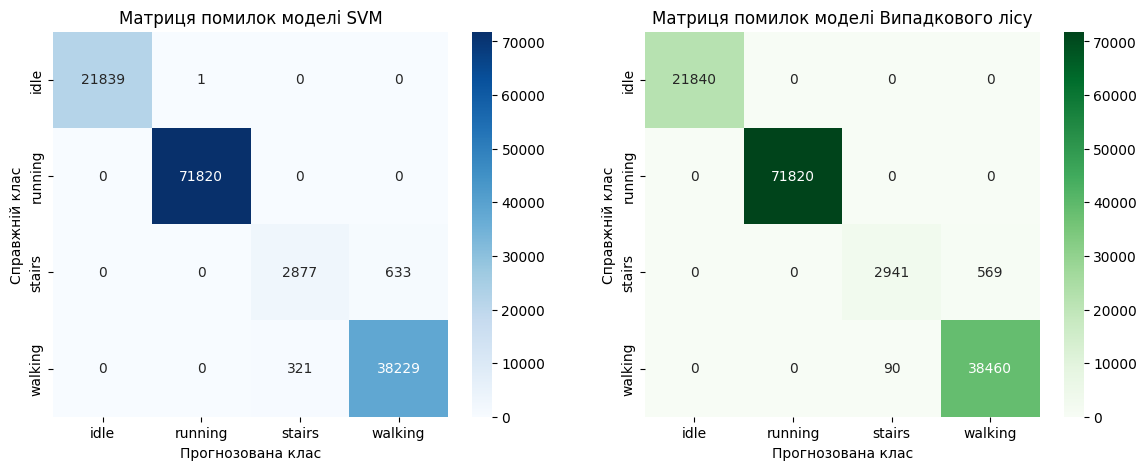

In [11]:
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)

print(f'Точність моделі SVM:{svm_score}')
print(f'Точність моделі випадкового лісу:{rf_score}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(svm_confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=df.folder.unique(), yticklabels=df.folder.unique(), ax=axes[0])
axes[0].set_title('Матриця помилок моделі SVM')
axes[0].set_xlabel('Прогнозована клас')
axes[0].set_ylabel('Справжній клас')

sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=df.folder.unique(), yticklabels=df.folder.unique(), ax=axes[1])
axes[1].set_title('Матриця помилок моделі Випадкового лісу')
axes[1].set_xlabel('Прогнозована клас')
axes[1].set_ylabel('Справжній клас')

plt.show()

В обох моделях високий рівень передбачення, але не 100%